## Small Dataset Full-Image Species Exploration 

In this notebook, we explore a small portion of Haiti Tree Project (THTP) captures labeled by Cam. These are full images and represent a small portion of the dataset (hence small). This notebook is for transfer learning using a pretrained Inception v3 classifier, same as that used by Pl@ntNet.


### Dependencies

In [19]:
import torch
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import urllib
import time

from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torchvision.models as models
from torchvision.io import read_image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader


import requests
import json


torch.backends.cudnn.benchmark = True

### Data Retrieval
 
 
For now, download each image/label pair Cam has specified ([Github link](https://gconfusion_matrixcom/Greenstand/Tree_Species/tree/master/training)).

In [20]:
datadir = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/cam_training.psv"
baseurl = "https://treetracker-production-images.s3.eu-central-1.amazonaws.com/"
assert os.path.exists(datadir)
data = pd.read_csv(datadir, sep="|", header=None)
data.columns = ["class", "imname"]
data["url"] = baseurl + data["imname"]
data.head(5)

,class,imname,url
0,ACACAURI,2020.11.29.12.18.36_18.285143729299307_-73.564...,https://treetracker-production-images.s3.eu-ce...
1,ACACAURI,2020.11.29.12.18.59_18.285102993249893_-73.564...,https://treetracker-production-images.s3.eu-ce...
2,ACACAURI,2020.11.29.12.47.34_18.290133895352483_-73.557...,https://treetracker-production-images.s3.eu-ce...
3,ACACAURI,2020.11.29.12.47.48_18.29019017983228_-73.5579...,https://treetracker-production-images.s3.eu-ce...
4,ACACAURI,2020.11.29.12.50.51_18.29083981923759_-73.5582...,https://treetracker-production-images.s3.eu-ce...


In [21]:
savepath = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/"
for species in data["class"].unique():
    if not os.path.exists(os.path.join(savepath, species)):
        os.makedirs(os.path.join(savepath, species))
        
def image_saver(df):
    try:
        urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
        return True
    except:
        return False
    
        
# image_saver = lambda df: urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
data["saved"] = data.apply(image_saver, axis=1)
print (data[data["saved"]].shape[0], " images saved out of ", data.shape[0])

710  images saved out of  772


710  total valid samples
Class breakdown
{'ACACAURI': 130, 'ANACOCCI': 86, 'CATALONG': 100, 'CEDRODOR': 113, 'MANGINDI': 221, 'SIMAGLAU': 60}
6  classes found


Text(0.5, 1.0, 'Count per class')

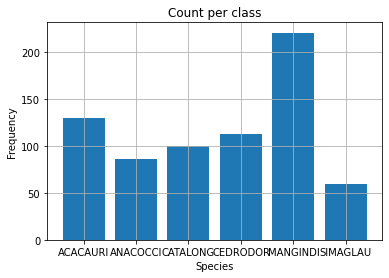

In [22]:
data = data[data["saved"]]
print (data.shape[0], " total valid samples")
print ("Class breakdown")
count_by_class = data.groupby("class").aggregate("count")
baseline_acc = np.max
print (dict(zip(count_by_class.index, count_by_class.values[:, 0])))
num_classes = data["class"].unique().shape[0]
print (num_classes, " classes found")
plt.bar(count_by_class.index, count_by_class["imname"])
plt.grid()
plt.xlabel("Species")
plt.ylabel("Frequency")
plt.title("Count per class")

In [23]:
arrs = []
labels = []
import logging 
# You must initialize logging, otherwise you'll not see debug output.
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

for species in data["class"].unique():
    for img in os.listdir(os.path.join(savepath, species)):
        if os.path.splitext(os.path.join(savepath, species, img))[1].lower() in [".jpg", ".png"]:
            arrs.append(Image.open(os.path.join(savepath, species, img)).resize((299, 299)))
            labels.append(species)
            


## Visualize a few images, explore features



In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import feature
from skimage.color import rgb2gray
from skimage.filters import * 
import cv2 

n_imgs = 9
idxs = np.random.choice(np.arange(0, len(arrs)), replace=False, size=n_imgs)
f, axarr = plt.subplots(int(np.sqrt(n_imgs)), int(np.sqrt(n_imgs)), figsize=(10 ,10))


params = cv2.SimpleBlobDetector_Params()

params.filterByArea = True
params.minArea = 600
params.maxArea = 10000

params.filterByCircularity = False
params.minCircularity = 0.1
params.maxCircularity =0.6

params.filterByConvexity = True
params.minConvexity = 0.0
params.maxConvexity=0.6

params.filterByInertia = True
params.minInertiaRatio = 0.2
params.maxInertiaRatio=0.9

detector = cv2.SimpleBlobDetector_create(params)

preprocessing = lambda img: gaussian(feature.canny(rgb2gray(np.array(img)), sigma=1), 3)
# preprocessing = lambda img: gabor(rgb2gray(np.array(img)), frequency=3, theta=90)[0]
preprocess = []
for i in range(int(np.sqrt(n_imgs))):
    for j in range(int(np.sqrt(n_imgs))):
        idx = idxs[i * int(np.sqrt(n_imgs)) + j]
        img = np.array(arrs[idx])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # axarr[i, j].imshow(feature.canny(rgb2gray(np.array(arrs[idx]))))
        keypoints = detector.detect(gray)
        img_to_show = cv2.drawKeypoints(gray, keypoints, np.zeros((1,1)), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axarr[i, j].imshow(img_to_show, cmap='gray')
        axarr[i, j].set_title(labels[idx])
plt.show()
    

In [ ]:
X = np.vstack([preprocessing(img).flatten() for img in arrs])
pca = PCA(n_components=50)
X_red = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_ * 100))
print (np.sum(pca.explained_variance_ratio_) * 100 , "% variance explained total")

In [ ]:
X_embedded = TSNE(n_components=2, perplexity=80.0, learning_rate=24.0, n_iter=10000).fit_transform(X_red)
tsne_result = pd.DataFrame(X_embedded)
tsne_result["class"] = labels
tsne_result.columns = ["x0", "x1", "class"]
colors = np.linspace(0, 1, len(data["class"].unique()))
colordict = dict(zip(data["class"].unique(), colors))  
tsne_result["Color"] = tsne_result["class"].apply(lambda x: colordict[x])

In [ ]:
print (tsne_result.head(5))

In [ ]:
plt.grid()
plt.scatter(tsne_result["x0"], tsne_result["x1"], c=tsne_result["Color"], label=tsne_result["class"])


## Prepare dataset for training

In [12]:
class HaitiDataset(torch.utils.data.Dataset):
    def __init__(self, df, loadpath, transform, encoding):
        '''
        A dataset with image names, classes, and a provided loading path to load images from
        '''
        self.loadpath = loadpath
        self.data = df
        self.n_classes = self.data["class"].unique().shape[0]
        self.transform = transform
        self.numerical_encoding = dict(zip(sorted(list(self.data["class"].unique())), list(range(self.n_classes))))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.loadpath, self.data.iloc[idx, :]["class"], self.data.iloc[idx, :]["imname"])
        label = self.data.iloc[idx, :]["class"]
        img = self.transform(Image.open(img_path))
        label = self.numerical_encoding[label]
        return img, label
        
    def make_class_weighting(self):
        count_by_class = data.groupby("class").aggregate("count") 
        count_by_class = count_by_class / count_by_class.sum()
        count_by_class.index = count_by_class.index.map(self.numerical_encoding)
        return count_by_class.values[:, 0]


In [24]:
val_split = 0.3

idxs = np.arange(data.shape[0])
np.random.shuffle(idxs)

aug_transform = T.Compose([T.Resize(299), 
                       T.CenterCrop(299), # need center 299 pixel for Inception v3 feature extractor
                       T.RandomRotation(degrees=[-90, 90]),
                       T.RandomHorizontalFlip(p=0.5), 
                       T.ColorJitter(contrast=[0, 0.1], brightness=[0, 0.1], hue=[0, 0], saturation=[0, 0]), 
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                      ])
val_transform  = T.Compose([T.Resize(299), 
                       T.CenterCrop(299), # need center 299 pixel for Inception v3 feature extractor
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                      ])


tr_idxs = idxs[:int (val_split * data.shape[0]), ...]
val_idxs = idxs[int (val_split * data.shape[0]):, ...]

tr_dataset = HaitiDataset(data.iloc[tr_idxs, :], savepath, aug_transform, None)
val_dataset = HaitiDataset(data.iloc[val_idxs, :], savepath, val_transform, None)

tr_dataloader = DataLoader(tr_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_idxs.shape[0], shuffle=True, num_workers=1, pin_memory=True)



In [25]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def predictor_helper(df, model, preprocess):
    path =  os.path.join(savepath, df["class"], df["imname"])
    img = Image.open(path)
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    model.eval()
    with torch.no_grad():
        output = model(input_batch)
    return output.squeeze().numpy()

In [26]:
def feature_tsne(data, fv_col, pca_ndims=100):
    model_stack = np.vstack([fv for fv in data[fv_col].values])
    pca = PCA(n_components=pca_ndims)
    X_red = pca.fit_transform(model_stack)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_ * 100))
    print (np.sum(pca.explained_variance_ratio_) * 100 , "% variance explained total")
    model_embedding = TSNE(n_components=2, perplexity=80.0, learning_rate=20.0, n_iter=15000).fit_transform(X_red)
    tsne_model_result = pd.DataFrame(model_embedding)
    tsne_model_result["class"] = labels
    tsne_model_result.columns = ["x0", "x1", "class"]

    # Make figure
    f = plt.figure(figsize=(20, 10))
    scatter = plt.scatter(tsne_model_result["x0"], tsne_model_result["x1"], c=tsne_model_result["class"].astype('category').cat.codes)
    plt.title("t-SNE of %d Haiti Species %s"%(num_classes, fv_col))
    plt.grid()
    plt.legend(handles=scatter.legend_elements()[0],
               labels=list(tsne_model_result["class"].astype('category').cat.categories),
               title="species",
               bbox_to_anchor=(1.2,0.75),
               loc='right')
    plt.show()

In [27]:
def train_model(model, criterion, tr_dataloader, val_dataloader, model_savepath,num_epochs=100, report_interval=1):
    torch.cuda.empty_cache()
    for epoch in range(num_epochs):
        running_loss = 0
        start = time.time()
        tr_acc_sum = 0
        tr_samples = 0
        n_tr_batches = 0
        for batch_x, batch_y in tr_dataloader:
            n_tr_batches += 1
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            output = model.forward(batch_x)
            if hasattr(output, "logits"):
                loss = criterion(output.logits, batch_y)
                tr_acc_sum += torch.sum(torch.argmax(output.logits, dim=1) == batch_y)
            else:
                loss = criterion(output, batch_y)
                tr_acc_sum += torch.sum(torch.argmax(output, dim=1) == batch_y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            tr_samples += batch_y.size()[0]
        cf_matx = None
        with torch.no_grad():
            n_val_batches = 0
            val_samples = 0
            running_val_loss = 0
            val_acc_sum = 0
            for val_x, val_y in val_dataloader:
                n_val_batches += 1
                val_x = val_x.to(device)
                val_y = val_y.to(device)
                val_output = model.forward(val_x)
                if hasattr(val_output, "logits"):
                    val_loss = criterion(val_output.logits, val_y)
                    preds = torch.argmax(val_output.logits, dim=1)
                else:
                    val_loss = criterion(val_output, val_y)
                    preds = torch.argmax(val_output, dim=1)
                running_val_loss += val_loss.item()
                val_acc_sum += torch.sum(preds == val_y) # wrote this way just in case there's batched validation
                val_samples += val_y.size()[0]
                cf_matx = confusion_matrix(preds.detach().cpu().numpy(), val_y.detach().cpu().numpy())
        if epoch % report_interval == 0:
            print ("Epoch %d finished in %f seconds"%(epoch + 1, time.time() - start))
            print ("Training/Validation Loss per Batch: %f/ %f"%(running_loss / n_tr_batches, running_val_loss / n_val_batches))
            print ("Training/Validation Accuracy (percent): %f /%f"%(100 * tr_acc_sum / tr_samples, 100 * val_acc_sum / val_samples))
            print ("Confusion matrix:")
            print (cf_matx)
            print ("=" * 40)
    torch.save(model.state_dict(), model_savepath)
    print ("Finished training")
    return model

Explained variation per principal component: [18.414433   10.050915    7.458213    6.59511     4.0729322   2.6407254
  2.3269904   2.1053874   1.9214497   1.8119646   1.571179    1.4686427
  1.3557202   1.3052992   1.2448168   1.1686364   1.0160601   1.0084285
  0.94523823  0.8871724   0.79035294  0.77463573  0.7107679   0.68530345
  0.63326013  0.61196697  0.58265316  0.5639221   0.5595649   0.5513863
  0.5293031   0.5069506   0.4992394   0.47912532  0.4585589   0.4364132
  0.4179476   0.40597707  0.38445944  0.38214183  0.3779233   0.34961462
  0.34439206  0.33574688  0.32039005  0.31653202  0.30942744  0.29529065
  0.28875065  0.2830085   0.2746854   0.26952612  0.26366812  0.25926313
  0.2562291   0.25316003  0.24343494  0.23641205  0.23151086  0.22790174
  0.22501561  0.22400501  0.2199203   0.20969138  0.20599142  0.20275865
  0.19876482  0.1925418   0.1864567   0.1842641   0.17952229  0.1748018
  0.17331411  0.1688508   0.16321889  0.16196527  0.15645131  0.15534449
  0.15226   

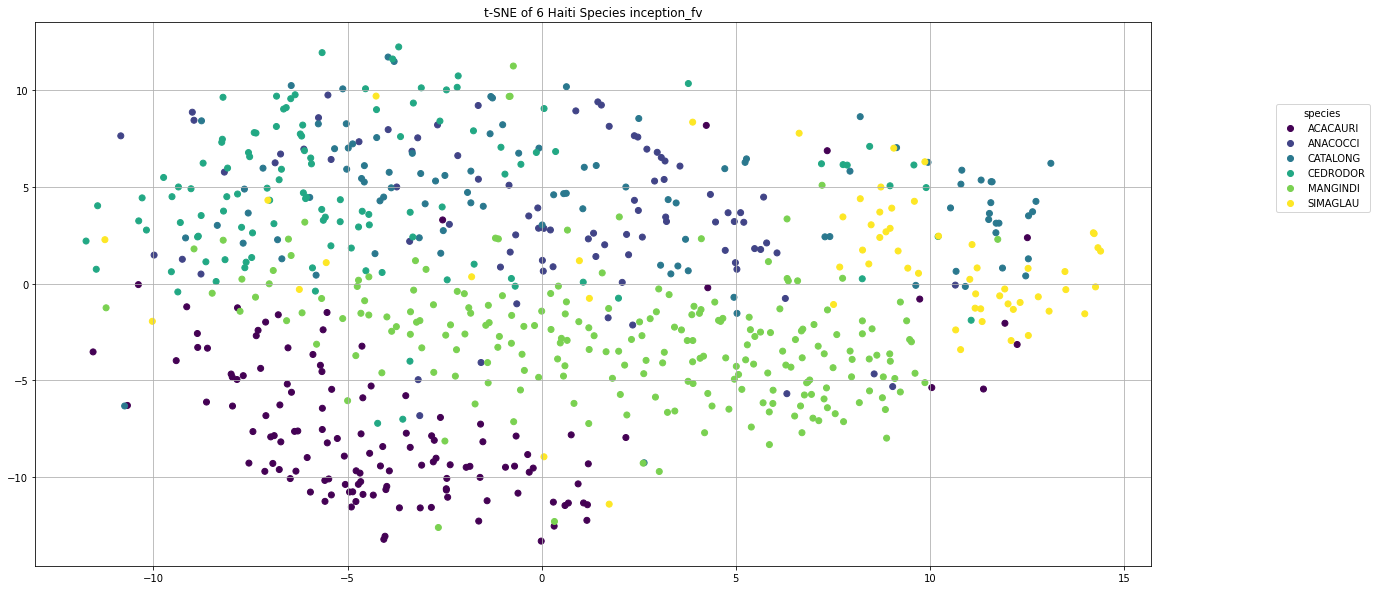

Device:  cuda:0
[Parameter containing:
tensor([[-0.0280,  0.0255,  0.0345,  ...,  0.0074, -0.0318,  0.0165],
        [-0.0311, -0.0356, -0.0230,  ..., -0.0235,  0.0345,  0.0296],
        [ 0.0291, -0.0196, -0.0088,  ..., -0.0335, -0.0042, -0.0175],
        [-0.0256, -0.0279,  0.0013,  ...,  0.0161, -0.0094,  0.0211],
        [ 0.0342,  0.0294, -0.0310,  ..., -0.0139, -0.0219, -0.0350],
        [ 0.0058,  0.0226, -0.0298,  ..., -0.0066, -0.0110, -0.0244]],
       requires_grad=True), Parameter containing:
tensor([ 0.0330,  0.0266,  0.0028,  0.0274,  0.0176, -0.0017],
       requires_grad=True), Parameter containing:
tensor([[-0.0111,  0.0110,  0.0182,  ...,  0.0189, -0.0203, -0.0054],
        [ 0.0105, -0.0027, -0.0089,  ..., -0.0186,  0.0039,  0.0009],
        [-0.0202, -0.0168, -0.0070,  ...,  0.0127, -0.0172, -0.0010],
        [ 0.0023,  0.0190,  0.0160,  ..., -0.0102, -0.0063,  0.0067],
        [-0.0203,  0.0190, -0.0116,  ...,  0.0180, -0.0170, -0.0153],
        [ 0.0218,  0.0122, 

In [28]:
inception = models.inception_v3(pretrained=True)
set_parameter_requires_grad(inception, feature_extracting=True)

inception_ft_preprocess = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data['inception_fv'] = data.apply(predictor_helper, axis=1, model=inception, preprocess=inception_ft_preprocess)
feature_tsne(data, 'inception_fv', 100)
num_ftrs = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = torch.nn.Linear(num_ftrs, num_classes)

# Handle the primary net
num_ftrs = inception.fc.in_features
inception.fc = torch.nn.Linear(num_ftrs,num_classes)

params_to_update = []
for name, param in inception.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("Device: ", device)
print (params_to_update)
class_weights = tr_dataset.make_class_weighting()
criterion = torch.nn.CrossEntropyLoss(reduction="mean", weight=torch.Tensor(class_weights)).cuda()
inception = inception.to(device)
inception.train()
optimizer = torch.optim.Adam(params_to_update, lr=5e-4, weight_decay=1e-4)


In [29]:
import datetime 

savepath = os.path.join(str(datetime.datetime.today().date()) + ".pt")
trained_model = train_model(inception, criterion, tr_dataloader, val_dataloader, savepath, 100, report_interval=5)


Epoch 1 finished in 24.963881 seconds
Training/Validation Loss per Batch: 1.722081/ 1.426928
Training/Validation Accuracy (percent): 20.657278 /35.211266
Confusion matrix:
[[  4   4   2   0   2   1]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [ 85  52  63  75 171  38]
 [  0   0   0   0   0   0]]
Epoch 6 finished in 25.533479 seconds
Training/Validation Loss per Batch: 1.460803/ 1.332819
Training/Validation Accuracy (percent): 29.577465 /39.839031
Confusion matrix:
[[ 23   5   5   2   5   1]
 [  0   1   0   0   1   0]
 [  0   0   0   0   1   1]
 [  1   4   2   9   1   1]
 [ 65  46  58  64 165  36]
 [  0   0   0   0   0   0]]
Epoch 11 finished in 25.580274 seconds
Training/Validation Loss per Batch: 1.284221/ 1.266874
Training/Validation Accuracy (percent): 41.784039 /49.496979
Confusion matrix:
[[ 47   7   9   7  11  10]
 [  0   3   0   0   0   0]
 [  0   1   9   1   4   1]
 [  0   9   9  37   8   5]
 [ 42  36  38  30 150  23]
 [  0   0   0   0   0 

In [43]:
inception.load_state_dict(torch.load("model_params/2022-03-24.pt"), strict=False)
inception.cuda()
inception.eval()
label_decode = {y:x for x,y in val_dataset.numerical_encoding.items()}
val_imgs = []
preds = []
labels = []

print (label_encode)
for j in range(len(val_dataset)):
    pred = int(torch.argmax(inception.forward(torch.unsqueeze(val_dataset[j][0], 0).cuda())).cpu().numpy())
    label = val_dataset[j][1]
    val_imgs.append(val_dataset[j][0].permute(1, 2, 0))
    preds.append(label_decode[pred])
    labels.append(label_decode[label])
    
    

{0: 'ACACAURI', 1: 'ANACOCCI', 2: 'CATALONG', 3: 'CEDRODOR', 4: 'MANGINDI', 5: 'SIMAGLAU'}


In [ ]:
# Run these in terminal if the carousel doesn't work
# ! conda install -c conda-forge ipympl
# ! conda install nodejs
# ! jupyter labextension install @jupyter-widgets/jupyterlab-manager
# ! conda install ipympl
# !jupyter lab build

In [9]:

i = 0
def make_carousel(fig, imgs, labels, preds):
    def img_helper(f, img):
        f.add_subplot(111)
        plt.imshow(img)
    
    def onclick1(fig):
        global i
        print(i)
        fig.clear()
        i += 1
        i %= len(imgs)
        switch_figs[i](fig)
        fig.canvas.draw()
        plt.draw()
        
    lambdas = [lambda f: img_helper(f, img) for img in imgs]
    switch_figs = dict(enumerate(lambdas))
    print (len(lambdas))

    switch_figs[0](fig)
    fig.canvas.callbacks.connect('pick_event', onclick1)    
    plt.show()
make_carousel(plt.figure(), val_imgs, None, None)

ModuleNotFoundError: No module named 'ipympl'

## Resnet


In [ ]:
resnet = models.resnet18(pretrained=True)
resnet_ft_preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data['resnet_fv'] = data.apply(predictor_helper, axis=1, model=resnet, preprocess=resnet_ft_preprocess)
set_parameter_requires_grad(resnet, feature_extracting=True)
feature_tsne(data, 'resnet_fv', 100)
# resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)


In [26]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("Device: ", device)
print (params_to_update)
class_weights = tr_dataset.make_class_weighting()
criterion = torch.nn.CrossEntropyLoss(reduction="mean", weight=torch.Tensor(class_weights)).cuda()
resnet = resnet.to(device)
resnet.train()
optimizer = torch.optim.Adam(params_to_update, lr=1e-3, weight_decay=1e-4)

Device:  cuda:0
[Parameter containing:
tensor([[ 0.0160,  0.0083,  0.0413,  ...,  0.0004, -0.0305,  0.0125],
        [ 0.0006, -0.0131, -0.0082,  ..., -0.0202,  0.0381, -0.0142],
        [-0.0233, -0.0146,  0.0075,  ..., -0.0389, -0.0211,  0.0253],
        [ 0.0310,  0.0157, -0.0223,  ...,  0.0064,  0.0433, -0.0195],
        [-0.0197, -0.0389, -0.0179,  ..., -0.0058,  0.0379,  0.0225],
        [ 0.0081,  0.0378,  0.0400,  ..., -0.0318,  0.0070, -0.0274]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.0207,  0.0219,  0.0040,  0.0159,  0.0386, -0.0272], device='cuda:0',
       requires_grad=True)]


In [ ]:
resnet_transform =transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

resnet_tr_dataset = HaitiDataset(data.iloc[tr_idxs, :], savepath, resnet_transform, None)
resnet_val_dataset = HaitiDataset(data.iloc[val_idxs, :], savepath, resnet_transform, None)

resnet_tr_dataloader = DataLoader(resnet_tr_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
resnet_val_dataloader = DataLoader(resnet_val_dataset, batch_size=val_idxs.shape[0], shuffle=True, num_workers=1, pin_memory=True)


train_model(resnet, criterion, resnet_tr_dataloader, resnet_val_dataloader, 100)

Explained variation per principal component: [15.950658   10.197018    7.0865097   5.3097863   3.8562565   3.2193384
  2.8675094   2.2569125   1.8866559   1.8763889   1.6282377   1.5313106
  1.3823315   1.3098458   1.216342    1.1202374   1.059854    1.0431799
  0.9635737   0.9369926   0.89467114  0.83501947  0.7251442   0.708446
  0.6928109   0.65130323  0.6312378   0.6060742   0.59815586  0.5535824
  0.52986556  0.5097439   0.49321628  0.47613963  0.45040604  0.43557003
  0.4252381   0.40689647  0.39391917  0.38257545  0.3787797   0.36258066
  0.3605402   0.34350812  0.32725585  0.3214988   0.31331986  0.30985245
  0.29811502  0.29436624  0.28487843  0.2843782   0.27053607  0.26630053
  0.25671053  0.25117275  0.2488056   0.24565318  0.23996744  0.22888267
  0.22580123  0.21963038  0.21352763  0.20788088  0.20358223  0.20263097
  0.1953113   0.1938607   0.18820581  0.18382494  0.17847909  0.17504913
  0.17362493  0.1682798   0.16554777  0.16405502  0.16091852  0.15890558
  0.15724002

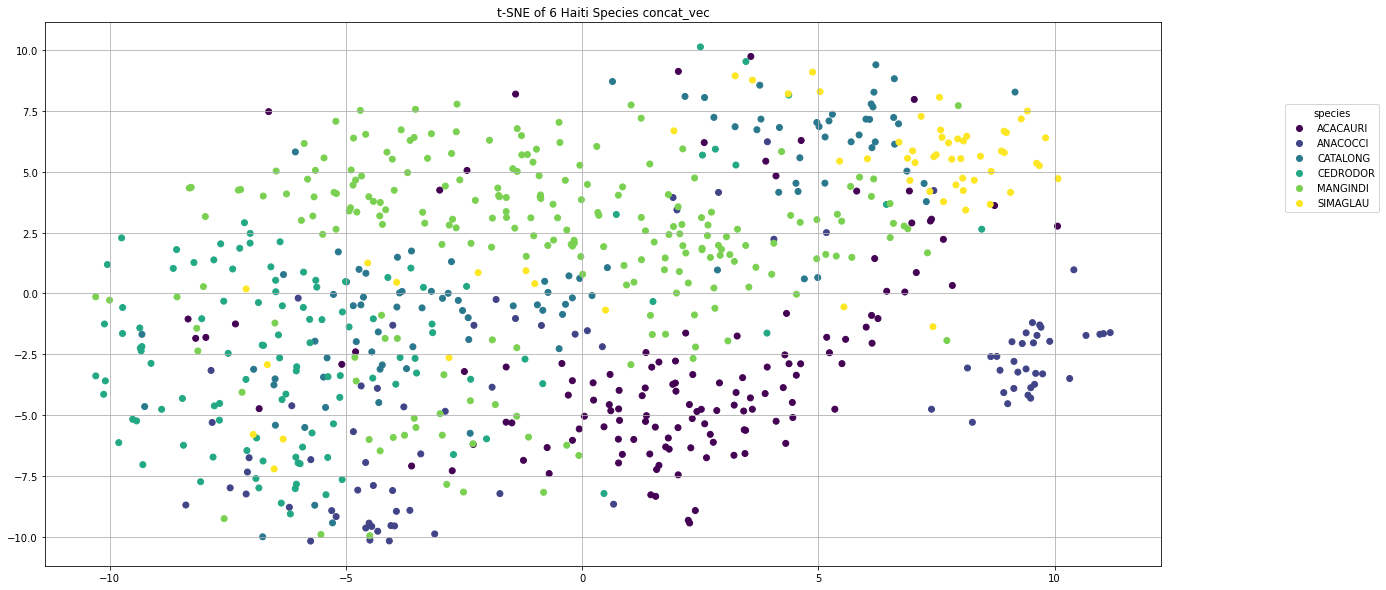

In [83]:
inception_size = data.iloc[0]['inception_fv'].shape
resnet_size = data.iloc[0]['resnet_fv'].shape
concat_vecs = lambda df: np.concatenate([df["inception_fv"], df["resnet_fv"]], axis=None)
data['concat_vec'] = data.apply(concat_vecs, axis=1)
feature_tsne(data, 'concat_vec', 250)

## Trying combined feature vectors 

In [91]:
class VectorDataset(torch.utils.data.Dataset):
    def __init__(self, df, vec_column):
        '''
        A dataset with feature vectors precomputed, classes, and a provided loading path to load images from
        '''
        self.data = df
        self.vec_column = vec_column
        self.n_classes = self.data["class"].unique().shape[0]
        self.numerical_encoding = dict(zip(sorted(list(self.data["class"].unique())), list(range(self.n_classes))))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        vec = self.data.iloc[idx, :][self.vec_column]
        label = self.data.iloc[idx, :]["class"]
        label = self.numerical_encoding[label]
        return vec, label
        
    def make_class_weighting(self):
        count_by_class = data.groupby("class").aggregate("count") 
        count_by_class = count_by_class / count_by_class.sum()
        count_by_class.index = count_by_class.index.map(self.numerical_encoding)
        return count_by_class.values[:, 0]

linmodel = torch.nn.Sequential(
    torch.nn.Linear(in_features=2000, out_features=2048),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(in_features=2048, out_features=num_classes),
    torch.nn.Softmax()
)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

val_split = 0.3
num_epochs = 100

idxs = np.arange(data.shape[0])
np.random.shuffle(idxs)

tr_idxs = idxs[:int (val_split * data.shape[0]), ...]
val_idxs = idxs[int (val_split * data.shape[0]):, ...]

tr_dataset = VectorDataset(data.iloc[tr_idxs, :], "concat_vec")
val_dataset = VectorDataset(data.iloc[val_idxs, :], "concat_vec")

tr_dataloader = DataLoader(tr_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_idxs.shape[0], shuffle=True, num_workers=1, pin_memory=True)


class_weights = tr_dataset.make_class_weighting()
criterion = torch.nn.CrossEntropyLoss(reduction="mean", weight=torch.Tensor(class_weights)).cuda()
linmodel = linmodel.to(device)
linmodel.train()

optimizer = torch.optim.Adam(params_to_update, lr=1e-4, weight_decay=1e-4)



In [93]:
train_model(linmodel, criterion, tr_dataloader, val_dataloader, 500, report_interval=50)

Epoch 1 finished in 0.359374 seconds
Training/Validation Loss per Batch: 1.787500/ 1.793154
Training/Validation Accuracy (percent): 19.718309 /16.901407
Confusion matrix:
[[14 10  9  7 19  4]
 [18 15  4 19 41  6]
 [ 5  3  1  0  8  1]
 [ 7 10 10 11 26  0]
 [31 11 29 24 33 16]
 [19 12 14 17 33 10]]
Epoch 51 finished in 0.353194 seconds
Training/Validation Loss per Batch: 1.779539/ 1.796188
Training/Validation Accuracy (percent): 20.187794 /16.096579
Confusion matrix:
[[11  9  6  5 22  6]
 [18 17  5 17 37  5]
 [ 5  1  0  8  8  3]
 [13 15 10  7 24  2]
 [31  8 27 29 32  8]
 [16 11 19 12 37 13]]
Epoch 101 finished in 0.358271 seconds
Training/Validation Loss per Batch: 1.795049/ 1.806187
Training/Validation Accuracy (percent): 17.370892 /16.297787
Confusion matrix:
[[11  7  7 14 27  4]
 [16 13  7 22 31  7]
 [ 6  2  7  3  9  1]
 [13 15  9  7 26  3]
 [33  6 27 16 36 15]
 [15 18 10 16 31  7]]
Epoch 151 finished in 0.363662 seconds
Training/Validation Loss per Batch: 1.790324/ 1.794791
Training/